In [114]:
!pip3 install gatspy
!pip3 install feets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Fitting each light curve using FT and saving it as a pdf file**

In [3]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def FT_bestfit():
    route = '_data\\_TESS_lightcurves_outliercleaned\\'
    path = route
    print(path)
    
    if not os.path.exists(path):
        print(f"Directory {path} does not exist.")
        return
    
    for filename in glob.iglob(f'{path}/*/*'):
        # Generate the PDF filename properly
        pdf_filename = os.path.splitext(filename)[0] + '.pdf'
        
        # Create directory for the PDF if it doesn't exist
        pdf_dir = os.path.dirname(pdf_filename)
        if not os.path.exists(pdf_dir):
            os.makedirs(pdf_dir)
        
        data_in = pd.read_csv(filename, sep=',', names=['time', 'mag', 'magerr'], encoding='unicode_escape')
        tess_lc = data_in.to_records(index=False)
        a = tess_lc['time']
        b = tess_lc['mag']
        x = a / np.max(a)
        y = b / np.max(b)
        best_k = None
        best_rmse = float('inf')
        best_y_fit = None
        target_rmse = 0.0001
        
        for k in range(1, 901):
            y_fft = np.fft.fft(y)
            y_fft[k + 1:-k] = 0
            y_fit = np.fft.ifft(y_fft).real
            
            rmse = compute_rmse(y, y_fit)
            if rmse < best_rmse:
                best_rmse = rmse
                best_k = k
                best_y_fit = y_fit
                if best_rmse <= target_rmse:
                    break
        
        with PdfPages(pdf_filename) as pdf:
            fig = plt.figure(figsize=(10, 5))
            ax = fig.add_subplot(111)
            
            ax.plot(np.concatenate([x, 1 + x]), np.concatenate([y, y]), '--k', lw=2, label='True Data')
            ax.plot(np.concatenate([x, 1 + x]), np.concatenate([best_y_fit, best_y_fit]), color='gray', label=f'Best Fit (k={best_k})')
            
            ax.set_xlabel('phase')
            ax.set_ylabel('amplitude')
            ax.set_xlim(np.min(x), np.max(x))
            ax.set_ylim(np.min(y), np.max(y))
            ax.legend()
            
            pdf.savefig()
            plt.close(fig)
    
    print(f'All plots saved.')

# Call the function
FT_bestfit()



_data\_TESS_lightcurves_outliercleaned\
All plots saved.


 **This code run over a single directory and list all the features**

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os
import pandas as pd
import matplotlib.pyplot as plt
import feets

# Initialize lists to store features
name = []
ntype = []
ls = []
fvalues = ['name','type']

# Function to plot and save to PDF
def plot_light_curves_to_pdf(directory):
    route = '/content/drive/MyDrive/_TESS_lightcurves_outliercleaned/'
    path =  os.path.join(route,directory)
    print(path)

    f_oc = [os.path.join(path, file) for file in os.listdir(path)]
    print(f_oc)
    for file in f_oc:
        data_in = pd.read_csv(file, sep=',', names=['time', 'mag', 'magerr'], encoding='unicode_escape')
        tess_lc = data_in.to_records(index=False)
        fs = feets.FeatureSpace(data=['time', 'magnitude', 'error'])
        lc = [tess_lc['time'], tess_lc['mag'], tess_lc['magerr']]
        features, values = fs.extract(*lc)
        ls.append(values)
        i = os.path.basename(file)
        name.append(i)
        ntype.append(directory)
    fvalues.append(features)
    data = ls
    print(data)
    df = pd.DataFrame(data)
    df.columns = features

    df['name'] = name
    df['type'] = ntype

    # Rearrange columns to have 'name' and 'type' first
    cols = ['name', 'type'] + [col for col in df.columns if col not in ['name', 'type']]
    df = df[cols]

    df.to_csv(f'{directory}.csv', index=False, sep=',')
    return df

directory = input('Enter Directory name: ')
y = plot_light_curves_to_pdf(directory)


**Using Corner**

In [1]:
import corner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
l = "L.csv"
data_in = pd.read_csv(l, sep=',', names=['Amplitude', 'PeriodLS'], encoding='unicode_escape')
lc = data_in.to_records(index=False)

In [3]:
y = lc['Amplitude'][1:].astype(float)
x = lc['PeriodLS'][1:].astype(float)

sample = np.array(list(zip(x, y)))

print(len(sample))

236


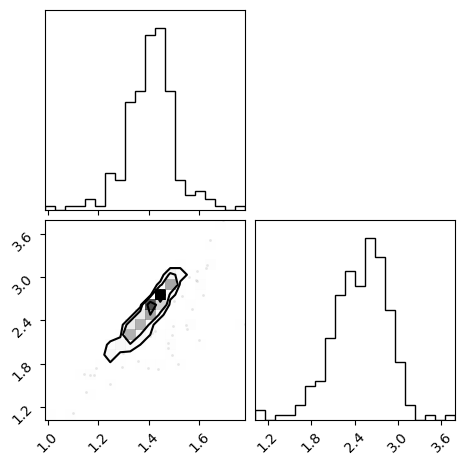

In [4]:
figure = corner.corner(sample)

In [11]:
dcep = "DCEP.csv"
hads = "HADS.csv"
data_in = pd.read_csv(dcep, sep=',', names=['Amplitude', 'PeriodLS','Mean'], encoding='unicode_escape')
lc_1 = data_in.to_records(index=False)
data_in = pd.read_csv(hads, sep=',', names=['Amplitude', 'PeriodLS','Mean'], encoding='unicode_escape')
lc_2 = data_in.to_records(index=False)

In [16]:
y = lc_1['Amplitude'][1:].astype(float)
x = lc_1['PeriodLS'][1:].astype(float)
z = lc_1['Mean'][1:].astype(float)
sample_1 = np.array(list(zip(x, y, z)))

y1 = lc_2['Amplitude'][1:].astype(float)
x1 = lc_2['PeriodLS'][1:].astype(float)
z1 = lc_2['Mean'][1:].astype(float)
sample_2 = np.array(list(zip(x1, y1, z1)))

print(len(sample_1))
print(len(sample_2))

77
31


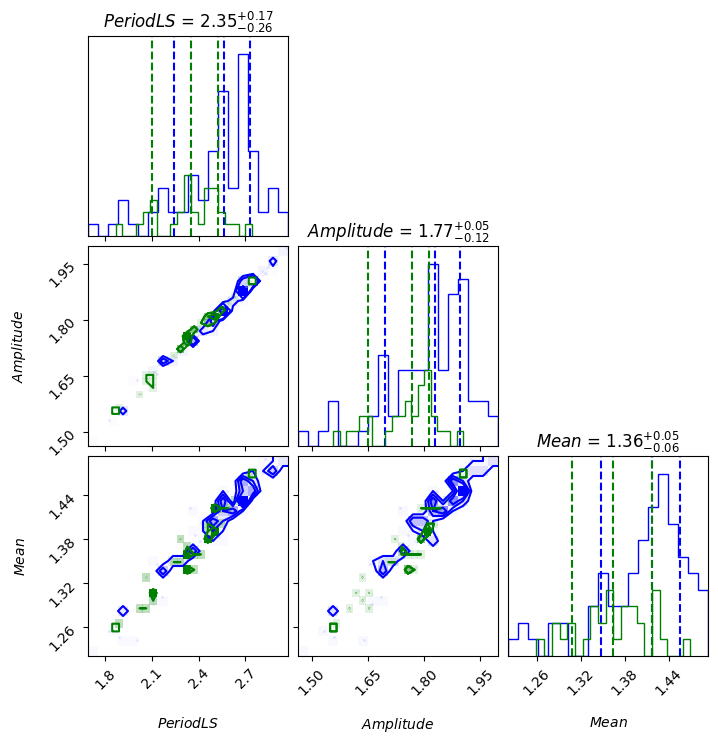

In [20]:
figure = corner.corner(sample_1, color = 'blue', labels=[r"$PeriodLS$", r"$Amplitude$", r"$Mean$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure = corner.corner(sample_2, labels=[r"$PeriodLS$", r"$Amplitude$", r"$Mean$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, color='green', fig=figure)

In [9]:
rot = 'ROT.csv' 
data_in = pd.read_csv(rot, sep=',', names=['Amplitude', 'PeriodLS','Mean'], encoding='unicode_escape')
lc_rot = data_in.to_records(index=False)

y = lc_rot['Amplitude'][1:].astype(float)
x = lc_rot['PeriodLS'][1:].astype(float)
z = lc_rot['Mean'][1:].astype(float)
sample_acv = np.array(list(zip(x, y,z)))

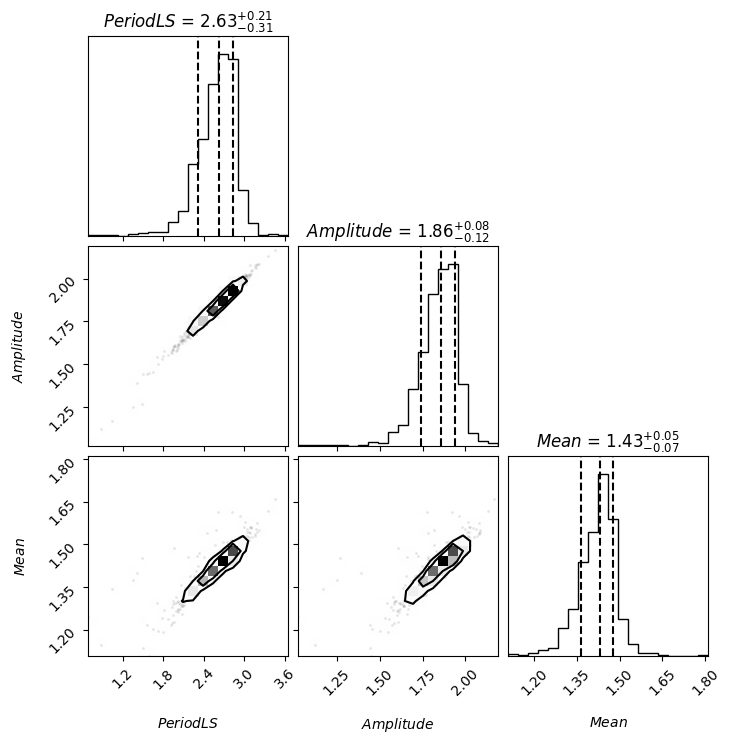

In [21]:
figure = corner.corner(sample_acv, labels=[r"$PeriodLS$", r"$Amplitude$", r"$Mean$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})